<b><h1 style="margin-bottom:-2px;text-align:center;">Facial Recognition and Identification for ABC</h1></b>
<p style="text-align:center;">
Final Project  - Synopsis <br>
By: Alireza Akramian Arani, Damien Liscio, Garnett Grant, James Yan, Jordi Llobet Ferre <br>
Professor: Vijayalakshmi Tiruchengode Angamuthu <br>
Centennial College - F24 - COMP257 - SEC.402 - Group 4<br>
</p>

<b><h2 style="margin-bottom:0px;">Description</h2></b>
In this Project, We have been approached by a law enforcement security company ABC that would like to incorporate facial recognition and identification into their system. ABC has provided our team with the <a href="https://cs.nyu.edu/~roweis/data/umist_cropped.mat"><u>umist_cropped.mat</u></a> dataset to train our system 

In [26]:
import scipy.io as sio  # for loading matlab files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

<b><h2 style="margin-bottom:0px;">Training</h2></b>
1. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set. Provide your rationale for the split ratio

<h3>Function - Organize Data and Flatten in Dataframe</h3>

<b>Data from Supported Documentation</b>
* Link - https://cs.nyu.edu/~roweis/data.html
* Grayscale Faces - 8 bit [0-255]
* 20 Different People
* 575 Total Images
* Size - 112 x 92


<b>Findings/Notes in Data Exploration</b>
* Dictionary When Loading
    * "dirname" - classification per group of images
    * "facedat" - groups of images per person
* Values Stored/Wrapped in Object Array
    * Third Value in Shapes Represent Instances of Image per Person
* Classification Values are String Values; Converted to Numerical Values for Efficiency/Simplicity
* Flattened Data Feature Length - 10304 (112 x 92)
* Converted Data to Dataframe for Clarity
* Appended Numerical Classification to Dataframe - "target"


In [27]:
def organizeData(file_path):
    
    # Import Data
    dataset = sio.loadmat(file_path)
    
    # Seperate Data (class/face position) 
    classification = dataset['dirnames']
    face_data = dataset['facedat']
    
    # Transform Classifications to Numerical
    for i in range(len(classification[0])):
        classification[0][i] = i
    
    # Create an empty list to append to dataframe later on
    face_data_list = []
    class_list = []
    
    
    # Grab Image and Classification Per Person
    for person_i in range(len(face_data[0])):                                                  # [0] -> Index to Get First Row to Access Data Directly
        print("==============================================================")
        print(f"Number of Images for Person {person_i}: {face_data[0][person_i].shape[2]}")                                                     
        
        for face_i in range(face_data[0][person_i].shape[2]):                                     
            # Verification and Visualization
            """
            print(face_data[0][person_i][:, :, face_i].shape)
            plt.imshow(face_data[0][person_i][:, :, face_i])
            plt.xticks([])
            plt.yticks([])
            plt.show()
            """
            # Append Data
            face_data_list.append(face_data[0][person_i][:, :, face_i].reshape(-1))             # Append Face Pics in Single Line
            class_list.append(str(classification[0][person_i]))                                 # Append Numerical Class Per Person

    
    data_org = pd.DataFrame(face_data_list)
    data_org['target'] = class_list

    return data_org

In [3]:
df_organized = organizeData('D:/coop3/FR-I-F24/umist_cropped.mat')
df_organized.head()

Number of Images for Person 0: 38
Number of Images for Person 1: 35
Number of Images for Person 2: 26
Number of Images for Person 3: 24
Number of Images for Person 4: 26
Number of Images for Person 5: 23
Number of Images for Person 6: 19
Number of Images for Person 7: 22
Number of Images for Person 8: 20
Number of Images for Person 9: 32
Number of Images for Person 10: 34
Number of Images for Person 11: 34
Number of Images for Person 12: 26
Number of Images for Person 13: 30
Number of Images for Person 14: 19
Number of Images for Person 15: 26
Number of Images for Person 16: 26
Number of Images for Person 17: 33
Number of Images for Person 18: 48
Number of Images for Person 19: 34


,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,target
0,233,234,234,233,234,232,232,168,99,78,...,154,151,147,143,140,141,141,140,136,0
1,234,234,234,234,233,232,202,98,79,77,...,154,150,147,141,140,137,138,137,137,0
2,234,234,234,234,233,230,225,109,85,84,...,174,168,164,157,152,151,148,145,145,0
3,234,234,234,234,234,234,234,232,229,205,...,168,162,157,155,150,144,144,142,143,0
4,234,234,234,234,234,234,234,234,229,211,...,176,170,164,162,157,152,150,148,148,0


<h3>Seperate Class and Features</h3>

In [28]:
target = df_organized['target']
features = df_organized.drop('target', axis=1)

<h3>Stratified Split: Train, Val, Test [60/20/20 Split]</h3>

In [29]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, stratify=target, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

<b><h2 style="margin-bottom:0px;">Analysis Report</h2></b>

2. In the analysis report, discuss the rationale behind how your team preprocess the data. Include the mathematical equations used and any dimensionality reduction applied to the instanced and discuss its relevance to the problem at hand. (Note that your team will receive more points if you perform data preprocessing that help improve the eventual training process.)

Lorem ipsum dolor sit amet consectetur adipisicing elit. Labore eveniet, reiciendis necessitatibus minus corporis cum consequatur laboriosam vero provident totam autem voluptate, non saepe exercitationem dolorum rem quae officiis quaerat consequuntur est laborum ea tempora officia incidunt. Facere, explicabo eaque. Nam aliquid repellat facilis, molestiae aspernatur perferendis minus. Voluptas explicabo velit, porro, et, voluptatem accusantium dicta nulla perferendis quia ad aut? Voluptates odio voluptatibus dolorum excepturi! Laborum magni consequatur tenetur voluptatem velit atque dolorum consectetur. Incidunt natus est provident? Reprehenderit cum ipsum quod? Repudiandae illo iure dolorum amet esse praesentium, obcaecati magni dolores perferendis omnis, deleniti placeat velit corrupti cum nulla est reprehenderit rerum laudantium, ad quos expedita fuga qui. At quas, repudiandae, eos iusto excepturi consequatur nisi perferendis voluptatibus velit distinctio hic deleniti nihil, suscipit doloribus non sapiente. Rerum incidunt impedit provident voluptas consectetur deserunt, consequuntur dicta. In, at consectetur quia mollitia incidunt expedita impedit? Numquam dignissimos, tenetur itaque saepe obcaecati quam voluptatum blanditiis debitis officia accusantium, reiciendis corporis fugiat voluptates vel magni quibusdam, odit id? Tenetur sit aspernatur soluta deserunt aut laboriosam qui? Commodi laboriosam fugiat reiciendis temporibus in nemo consequuntur, assumenda, ipsam repudiandae ullam porro consequatur saepe hic dolore eum omnis perspiciatis eos ratione quas labore dicta?

<h3>PCA Dimensionality Reduction</h3>

In [30]:
pca = PCA(n_components=0.99)
x_train_red = pca.fit_transform(x_train)
x_test_red = pca.transform(x_test)
x_val_red = pca.transform(x_val)

<h3>Standardize Pixel Values - Not Normalize!</h3>

In [31]:
scaler = StandardScaler()
x_train_pre = scaler.fit_transform(x_train_red)
x_test_pre = scaler.transform(x_test_red)
x_val_pre = scaler.transform(x_val_red)

<h3>One Hot Encode Labels</h3>

In [32]:
one_hot_train = tf.one_hot(y_train, depth=len(y_train.unique()))
one_hot_test = tf.one_hot(y_test, depth=len(y_test.unique()))
one_hot_val = tf.one_hot(y_val, depth=len(y_val.unique()))

<b><h2 style="margin-bottom:0px;">Clustering</h2></b>

3. Select a clustering technique taught in this course and apply it on the training instances. Provide the rationale behind your team’s choice of clustering technique and how your team tuned the parameters for the technique implemented. 

<h3>kMeans - Choosing the Optimal Number of Clusters from Silhouette Score</h3>

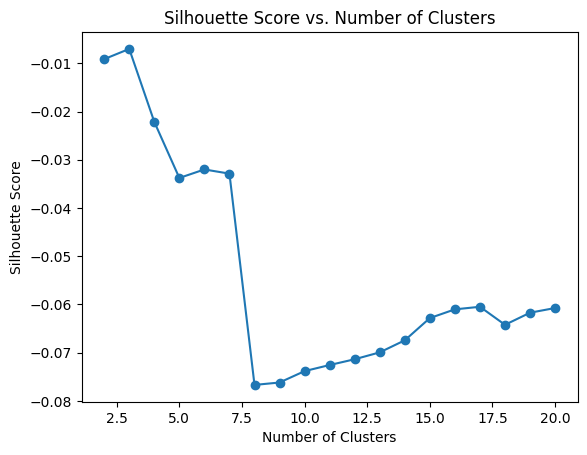

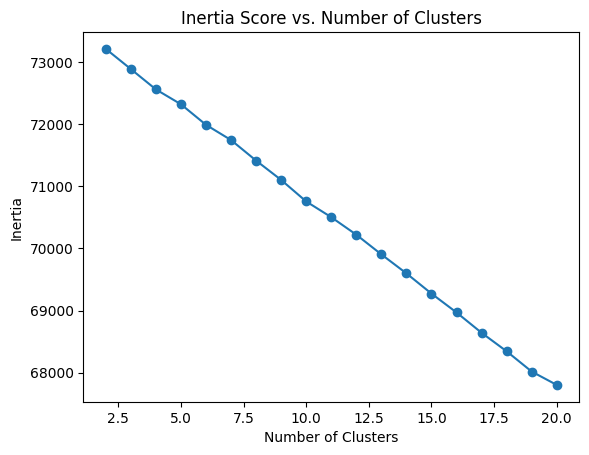

In [33]:
sil_scores = []
inertia_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x_train_pre)
    inertia_scores.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(x_train_pre, kmeans.labels_))

plt.plot(range(2, 21), sil_scores, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

plt.plot(range(2, 21), inertia_scores, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Score vs. Number of Clusters')
plt.show()

<h3>kMeans with Best Number of Clusters</h3>

In [34]:
best_kmeans = KMeans(n_clusters=3, random_state=42)
best_kmeans.fit(x_train_pre)

for i in range(3):
    unique, counts = np.unique(y_train[best_kmeans.labels_ == i], return_counts=True)
    print(f"Cluster {i}: {unique}\nNumber of Images: {sum(counts)}")

Cluster 0: ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '4' '5'
 '6' '7' '8' '9']
Number of Images: 297
Cluster 1: ['0' '10' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '5' '6' '8' '9']
Number of Images: 43
Cluster 2: ['6' '8' '9']
Number of Images: 5


<h3>Feature Engineering - Euclidean Distance from Centroid Features</h3>

In [35]:
x_train_k = best_kmeans.transform(x_train_pre)
x_test_k = best_kmeans.transform(x_test_pre)
x_val_k = best_kmeans.transform(x_val_pre)

<h3>Feature Engineering - Assigned Centroid Feature</h3>

In [36]:
label_train = best_kmeans.labels_
label_test = best_kmeans.predict(x_test_pre)
label_val = best_kmeans.predict(x_val_pre)

k_train_cl_oh = tf.one_hot(label_train, depth=len(np.unique(label_train)))
k_test_cl_oh = tf.one_hot(label_test, depth=len(np.unique(label_train)))
k_val_cl_oh = tf.one_hot(label_val, depth=len(np.unique(label_train)))

<h3>Concatenate to Get Final Dataset</h3>

In [37]:
x_train_transf = np.concatenate((x_train_pre, x_train_k, k_train_cl_oh), axis=1)
x_test_transf = np.concatenate((x_test_pre, x_test_k, k_test_cl_oh), axis=1)
x_val_transf = np.concatenate((x_val_pre, x_val_k, k_val_cl_oh), axis=1)

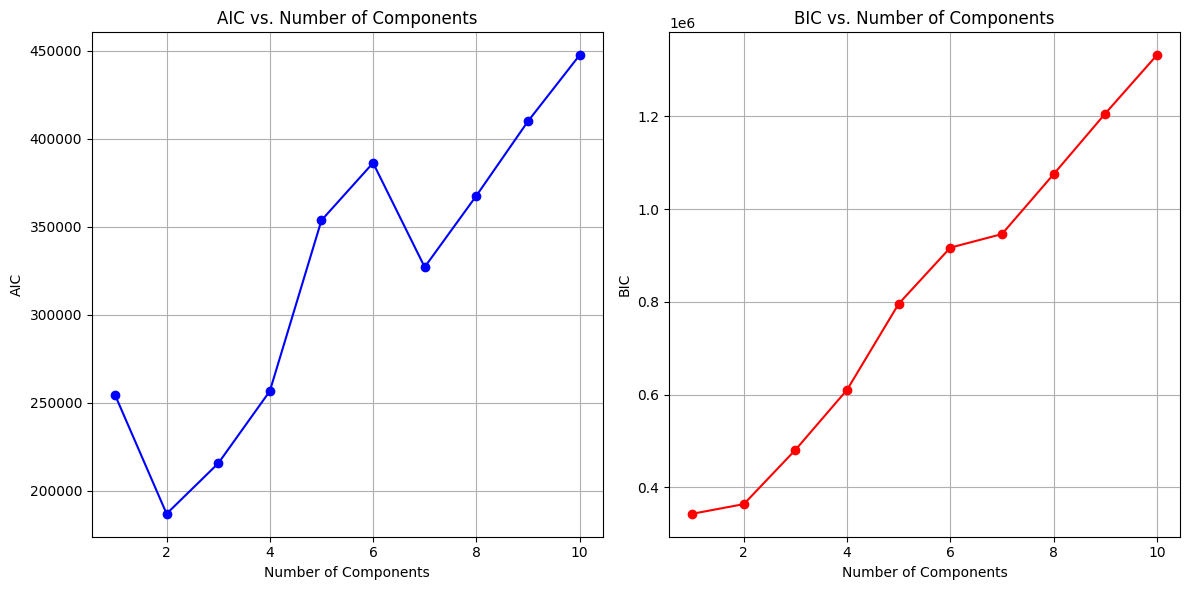

In [38]:
# Fit GMM models with varying numbers of components
aic_scores = []
bic_scores = []
n_components_range = range(1, 11)  # Testing with 1 to 10 components

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(x_train_pre)  # x_train_pre is the preprocessed training data
    aic_scores.append(gmm.aic(x_train_pre))
    bic_scores.append(gmm.bic(x_train_pre))

# Plot AIC and BIC scores
plt.figure(figsize=(12, 6))

# Plot AIC
plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_scores, marker='o', color='b', label='AIC')
plt.title('AIC vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.grid(True)

# Plot BIC
plt.subplot(1, 2, 2)
plt.plot(n_components_range, bic_scores, marker='o', color='r', label='BIC')
plt.title('BIC vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.grid(True)

plt.tight_layout()
plt.show()

Apply Gaussian Mixture Model (GMM)

In [58]:
optimal_components = 1
gmm_model = GaussianMixture(n_components=optimal_components, random_state=42)
gmm_model.fit(x_train_pre)
# Get the cluster labels for the training, validation, and test sets
gmm_labels_train = gmm_model.predict(x_train_pre)
gmm_labels_val = gmm_model.predict(x_val_pre)
gmm_labels_test = gmm_model.predict(x_test_pre)

# Convert GMM labels into one-hot encoding for neural network
gmm_train_oh = tf.one_hot(gmm_labels_train, depth=3)  # 3 clusters
gmm_val_oh = tf.one_hot(gmm_labels_val, depth=3)
gmm_test_oh = tf.one_hot(gmm_labels_test, depth=3)

# Concatenate the GMM labels (as new features) with the original data
x_train_gmm_transf = np.concatenate((x_train_pre, gmm_train_oh), axis=1)
x_val_gmm_transf = np.concatenate((x_val_pre, gmm_val_oh), axis=1)
x_test_gmm_transf = np.concatenate((x_test_pre, gmm_test_oh), axis=1)

# Check the final shape of the transformed data
print(f"x_train_gmm_transf shape: {x_train_gmm_transf.shape}")
print(f"x_val_gmm_transf shape: {x_val_gmm_transf.shape}")
print(f"x_test_gmm_transf shape: {x_test_gmm_transf.shape}")


x_train_gmm_transf shape: (345, 216)
x_val_gmm_transf shape: (115, 216)
x_test_gmm_transf shape: (115, 216)


<b><h2 style="margin-bottom:0px;">Analysis Report - Architecture</h2></b>

4. In the analysis report, clearly discuss - with illustrations - the architecture your team has selected for training and predicting the test instances. Discuss the rationale behind your team’s choice of activation functions, loss function, and how you tuned the hyperparameters of the network model.

Lorem ipsum dolor sit amet consectetur, adipisicing elit. Accusamus voluptatum repudiandae, magnam ab animi voluptates in veritatis ad optio dicta perferendis fuga non placeat libero corporis blanditiis deserunt eos commodi aliquid atque debitis. Illo officia hic ad neque optio consequuntur dolores enim quibusdam unde libero sint ea facere, repudiandae dignissimos voluptatem cupiditate ipsa consectetur magni aperiam ullam quod culpa animi nostrum est! Eos, voluptatibus asperiores? Assumenda cupiditate omnis rerum doloribus, inventore dolore vero quam alias reiciendis illum earum quisquam, officia ex, tempora iusto sit! Vitae repudiandae exercitationem accusamus? Mollitia autem iure recusandae odio vero harum, quis ipsa! Quidem, facilis placeat!

<h3>MLP Model w/ Basic Original Dataset</h3>

In [40]:
base_model = Sequential()
base_model.add(Input(shape=(x_train_pre.shape[1],)))
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(len(y_train.unique()), activation='softmax'))

base_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

base_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,948 (144.33 KB)

 Trainable params: 36,948 (144.33 KB)

 Non-trainable params: 0 (0.00 B)

<h3>MLP Model w/ Feature Engineered Dataset</h3>

In [41]:
k_model = Sequential()
k_model.add(Input(shape=(x_train_transf.shape[1],)))
k_model.add(Dense(128, activation='relu'))
k_model.add(Dense(64, activation='relu'))
k_model.add(Dense(len(y_train.unique()), activation='softmax'))

k_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

k_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,716 (147.33 KB)

 Trainable params: 37,716 (147.33 KB)

 Non-trainable params: 0 (0.00 B)

GMM Model (Using GMM Transformed Features)

In [59]:
gmm_model_nn = tf.keras.Sequential()
gmm_model_nn.add(tf.keras.layers.Input(shape=(x_train_gmm_transf.shape[1],)))  # Input layer matching x_train_gmm_transf
gmm_model_nn.add(tf.keras.layers.Dense(128, activation='relu'))
gmm_model_nn.add(tf.keras.layers.Dense(64, activation='relu'))

# Update output layer to match the number of classes in y_train (20 classes)
gmm_model_nn.add(tf.keras.layers.Dense(20, activation='softmax'))  # Output layer for 20 classes

gmm_model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

gmm_model_nn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │        27,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,332 (145.83 KB)

 Trainable params: 37,332 (145.83 KB)

 Non-trainable params: 0 (0.00 B)

<b><h2 style="margin-bottom:0px;">Results</h2></b>

5. Discuss the results of the trained system in the report.

<h3>MLP Model w/ Basic Original Dataset</h3>

<h4>Training w/ Validation</h4>

In [43]:
base_model.fit(x_train_pre, one_hot_train, epochs=50, validation_data=(x_val_pre, one_hot_val)) 

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0562 - loss: 3.3503 - val_accuracy: 0.1043 - val_loss: 2.9325
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1902 - loss: 2.7138 - val_accuracy: 0.2000 - val_loss: 2.6931
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4150 - loss: 2.3084 - val_accuracy: 0.3913 - val_loss: 2.4651
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6735 - loss: 1.9172 - val_accuracy: 0.4522 - val_loss: 2.2329
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8606 - loss: 1.5766 - val_accuracy: 0.5652 - val_loss: 1.9949
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9174 - loss: 1.2527 - val_accuracy: 0.6870 - val_loss: 1.7536
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9684 - loss: 0.9360 - val_accuracy: 0.7478 - val_loss: 1.5147
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9924 - loss: 0.7033 - val_accuracy: 0.8348 - val_loss

<h4>Evaluating Test Data</h4>

In [44]:
base_results = base_model.evaluate(x_test_pre, one_hot_test)
print("test loss, test acc:", base_results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8881 - loss: 0.3811 
test loss, test acc: [0.4535861909389496, 0.886956512928009]


<h3>MLP Model w/ Basic Original Dataset</h3>

<h4>Training w/ Validation</h4>

In [45]:
k_model.fit(x_train_transf, one_hot_train, epochs=50, validation_data=(x_val_transf, one_hot_val)) 

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0436 - loss: 3.7053 - val_accuracy: 0.1043 - val_loss: 2.7741
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1587 - loss: 2.6726 - val_accuracy: 0.1826 - val_loss: 2.5328
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3173 - loss: 2.3561 - val_accuracy: 0.4609 - val_loss: 2.2777
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5372 - loss: 2.0259 - val_accuracy: 0.5565 - val_loss: 2.0065
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7291 - loss: 1.6233 - val_accuracy: 0.6522 - val_loss: 1.7348
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8884 - loss: 1.2500 - val_accuracy: 0.7652 - val_loss: 1.4680
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9172 - loss: 0.9604 - val_accuracy: 0.8348 - val_loss: 1.2178
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9755 - loss: 0.6734 - val_accuracy: 0.8522 - val_loss

<h4>Evaluating Test Data</h4>

In [46]:
k_results = k_model.evaluate(x_test_transf, one_hot_test)
print("test loss, test acc:", k_results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9587 - loss: 0.2321 
test loss, test acc: [0.2445916086435318, 0.95652174949646]


Train the GMM model

In [60]:
gmm_model_nn.fit(x_train_gmm_transf, one_hot_train, epochs=50, validation_data=(x_val_gmm_transf, one_hot_val)) 


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0810 - loss: 3.1441 - val_accuracy: 0.2174 - val_loss: 2.8107
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2788 - loss: 2.6038 - val_accuracy: 0.3130 - val_loss: 2.5773
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4988 - loss: 2.2240 - val_accuracy: 0.4000 - val_loss: 2.3619
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7419 - loss: 1.8241 - val_accuracy: 0.5130 - val_loss: 2.1155
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8459 - loss: 1.5312 - val_accuracy: 0.6609 - val_loss: 1.8576
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9454 - loss: 1.1552 - val_accuracy: 0.7304 - val_loss: 1.5970
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9825 - loss: 0.8327 - val_accuracy: 0.8174 - val_loss: 1.3531
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.5648 - val_accuracy: 0.8609 - val_loss

Evaluate the model on the test set

In [61]:
gmm_results = gmm_model_nn.evaluate(x_test_gmm_transf, one_hot_test)
print("GMM Model - Test loss, Test accuracy:", gmm_results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - loss: 0.2831 
GMM Model - Test loss, Test accuracy: [0.336982786655426, 0.9304347634315491]


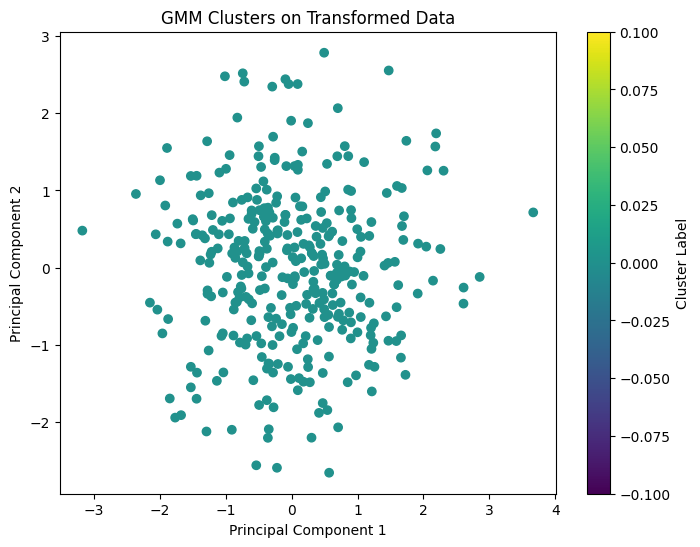

GMM Means:
[[ 9.33230948e-18  1.11022302e-17  1.02977208e-17  5.14886040e-18
   4.68827875e-17  9.49321137e-18  3.79728455e-17  9.65411326e-18
  -3.12149662e-17  6.43607551e-19  2.44570869e-17 -4.98795852e-18
   5.34194267e-17  1.41593661e-17 -3.02495549e-17 -1.25503472e-17
   2.30089699e-17 -2.02736378e-17  2.89623398e-17  1.60901888e-17
  -4.68224493e-17 -3.37893964e-17 -3.70074342e-17 -9.93569156e-18
  -1.44811699e-17  2.18826567e-17  3.79728455e-17 -6.85442041e-17
   9.01050571e-18  9.01050571e-18  3.41112002e-17 -6.43607551e-18
   2.25262643e-18 -1.33548567e-17  8.84960382e-19  3.21803775e-19
   9.01050571e-18  2.95254964e-17 -2.87209869e-17  1.99518341e-17
  -2.36928030e-17  4.85923701e-17 -1.46420718e-17  1.57683850e-17
   3.63638266e-17  1.50845520e-17 -4.24780983e-17 -3.21803775e-17
   3.21803775e-19 -2.34916756e-17  3.21803775e-18 -1.57683850e-17
   1.02977208e-17  2.09172454e-18  3.86164530e-18  1.94691284e-17
   1.57683850e-17 -6.43607551e-19  2.44570869e-17  8.04509438e-18

In [62]:
# Visual Exploration of GMM Clusters (Optional for 2D visualization)
from sklearn.decomposition import PCA

# Reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
x_train_2d = pca.fit_transform(x_train_pre)

# Plot GMM clusters
plt.figure(figsize=(8, 6))
plt.scatter(x_train_2d[:, 0], x_train_2d[:, 1], c=gmm_labels_train, cmap='viridis')
plt.title("GMM Clusters on Transformed Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Inspect GMM parameters (means, covariances, weights)
print("GMM Means:")
print(gmm_model.means_)

print("\nGMM Covariances:")
print(gmm_model.covariances_)

print("\nGMM Weights:")
print(gmm_model.weights_)

# Model Summary: Show GMM model fit evaluation (AIC, BIC)
print(f"AIC: {gmm_model.aic(x_train_pre)}")
print(f"BIC: {gmm_model.bic(x_train_pre)}")

<b><h2 style="margin-bottom:0px;">Demo</h2></b>

6. Demonstrate the project as a Team. In the analysis report, discuss the decisions your team made, the challenges your team encountered, how your team resolved the problems, and the results.

Lorem ipsum dolor, sit amet consectetur adipisicing elit. Inventore totam voluptates eos magni sequi fugit ab. Maxime fugiat blanditiis non beatae inventore corporis rem exercitationem molestias aspernatur consequatur expedita eos ducimus veritatis, odit iure rerum, at cumque vel debitis, optio culpa! In veniam ipsam quod dignissimos cumque vitae aut voluptates, dolorum nobis animi alias est dolor eum sit provident ut suscipit nostrum, blanditiis sunt veritatis recusandae quibusdam doloremque! Labore earum laboriosam temporibus maiores distinctio natus? Beatae nulla, aliquid natus consequuntur cum sunt error deserunt qui molestias culpa, quisquam, aliquam voluptatem! Atque quaerat blanditiis velit vitae porro ipsum eum iste tempora.